In [ ]:
#import pandas as pd
import numpy as np
import pandas as pd
import os
from statistics import mean
import tensorflow as tf
from PIL import Image
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
def get_sat_paths(directory):
    '''Creates a list of paths to the training satellite images'''
    sat_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            # add the actual pcitures to sat_pics:
            sat_paths
            sat_paths.append(os.path.join(directory, filename)) 
               
    return sat_paths

# Function to load images from path
def load_image(img_path):
    with Image.open(img_path) as img:
        return np.asarray(img)

In [ ]:
# LOAD DATAFRAMES
df_path = "Path/to/df.csv"
df = pd.read_csv(df_path)

In [ ]:
def preprocess_data(df, directory):
    '''Preprocesses the data by loading the images and their corresponding 
    demand values into numpy arrays and returns them.'''  
    # Create a list to store the image arrays and their corresponding Ids
    image_data = []
    demand_data = []

    # create target_df consisting of Id and Demand
    target_df = df[["Id", "Demand"]]

    # Iterate over image paths
    image_paths = get_sat_paths(directory)
    for img_path in image_paths:
        # Extract the Id from the filename by removing the path and extension
        img_id = os.path.splitext(os.path.basename(img_path))[0]

        # Find the demand value corresponding to the Id in the target dataframe
        demand = target_df.loc[target_df["Id"] == int(img_id), "Demand"].values[0]
        
        # Load the image as a numpy array
        image_array = load_image(img_path)
        assert(image_array.shape == (512, 512, 3))
        # Add the image data and demand to a list, in the same order
        image_data.append(image_array)
        #demand_data.append(demand)
    X = np.array(image_data)
    y = np.array(demand_data)
    return X, y

In [ ]:
image_path = "Path/to/images"
X, y = preprocess_data(df, image_path)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# CLEAN UP
del X
del y

In [ ]:
# BASELINE SCORES
model = DummyRegressor(strategy='mean')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Dummy Model:")
print("MSE:", mse)
print("MAE:", mae)

In [ ]:
# Set up input and augmentation layers
input_x =  layers.Input(shape=(512, 512, 3))

In [ ]:
# Load pre-trained model
dense_num="121"
densenet = keras.applications.DenseNet121(include_top=False,
                                      input_tensor=input_x,
                                      input_shape=(512,512, 3),
                                      weights='imagenet')
del input_x

for layer in densenet.layers:
    layer.trainable = False


In [ ]:
# Create a new model
new_model = Sequential([densenet,
                    layers.GlobalAveragePooling2D(),
                    layers.Dense(1024, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(512, activation='relu'),
                    layers.Dropout(0.4),
                    layers.Dense(256, activation='relu'),
                    layers.Dropout(0.6),
                    layers.Dense(1, activation='linear')
                    ])


In [ ]:
# Compile the model
new_model.compile(optimizer="Adam", loss='mse', metrics=['mae'])

In [ ]:
# SETUP BASE DATA AUGMENTATION
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.0],
)
datagen.fit(X_train)

In [ ]:
es = EarlyStopping(verbose=1, patience=10, restore_best_weights=True)

In [ ]:
# TRAIN MODEL
history = new_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, batch_size=32,  validation_data=[X_val, y_val] ,verbose=1, callbacks= es)

Epoch 1/50
33/33 [==============================] - 123s 3s/step - loss: 3118.2036 - mae: 41.8210 - val_loss: 2555.4392 - val_mae: 39.7539
Epoch 2/50
33/33 [==============================] - 83s 3s/step - loss: 3171.6543 - mae: 41.4846 - val_loss: 2637.0969 - val_mae: 39.3894
Epoch 3/50
33/33 [==============================] - 84s 3s/step - loss: 2984.0293 - mae: 39.6419 - val_loss: 3224.6243 - val_mae: 46.1810
Epoch 4/50
33/33 [==============================] - 82s 3s/step - loss: 3210.5154 - mae: 42.4697 - val_loss: 2881.8674 - val_mae: 44.1099
Epoch 5/50
33/33 [==============================] - 82s 2s/step - loss: 3052.6365 - mae: 40.6200 - val_loss: 2611.9282 - val_mae: 41.0194
Epoch 6/50
33/33 [==============================] - 79s 2s/step - loss: 3061.8406 - mae: 40.5522 - val_loss: 2625.9880 - val_mae: 40.7417
Epoch 7/50
33/33 [==============================] - 81s 2s/step - loss: 3364.9922 - mae: 42.4331 - val_loss: 2583.7544 - val_mae: 40.7929
Epoch 8/50
33/33 [===============

KeyboardInterrupt: ignored

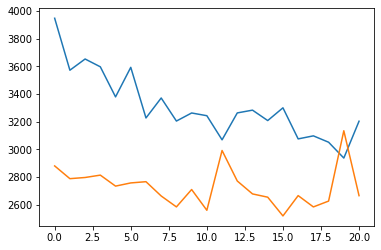

In [ ]:
# QUICK LOOK AT THE LOSS
import matplotlib.pyplot as plt
plt.plot(history.history["loss"][2:])
plt.plot(history.history["val_loss"][2:])

In [ ]:
def fine_tune(model):
    '''Unfreezes pre-trained model and trains it again.'''
    
    # In case of lacking memory/processing power, only train the last num layers
    # idx = 0
    # num = 20
    # for layer in reversed(model.layers[0].layers):
    #     if layer.name.endswith("_conv") and idx < 20:
    #         layer.trainable = True
    #         idx += 1
    #     else:
    #     layer.trainable = False
    
    for layer in model.layers[0].layers:
        layer.trainable = True
    
    # Adds a plateu to the learning rate
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
    
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        epochs=50, 
                        batch_size=32,  
                        validation_data=[X_val, y_val], 
                        verbose=1, 
                        callbacks= [lr_callback, es])
    
    return history, model

In [ ]:
fine_history, fine_model = fine_tune(new_model)